In [8]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import cv2
import os
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.python.data import Dataset
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Activation, Add, Attention, Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Conv1D
import keras
from keras.preprocessing import image

In [9]:
letter_count = 6
letter_width = 30
width = letter_width * letter_count
height = 40
letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
image_types = ["full color", "part color"]

In [10]:
fonts = os.listdir('fonts')
fonts =  ["fonts/" + font for font in fonts]
print(fonts)

['fonts/times new roman bold.ttf', 'fonts/SLC_.ttf', 'fonts/Roboto-Bold.ttf', 'fonts/Raleway-Bold.ttf', 'fonts/G_ari_bd.TTF']


In [11]:
def letter_to_image(letter: str, start: tuple[float, float], rotate, font: str, font_size: int, color: tuple[int, int, int]):
    img = Image.new("RGBA", (letter_width * 2, height * 2), (0,0,0,0))
    font = ImageFont.truetype(font, size=font_size)
    letter_pos = font.getbbox(letter)
    x, y = start
    # if letter_width < letter_pos[2]:
    #     x = 0
    # if letter_width < letter_pos[3]:
    #     y = 0
    # x = max (start[0], letter_width - letter_pos[2])
    # y = max (start[1], height - letter_pos[3])
    # x = min (x, 0 - letter_pos[0])
    # y = min (y, 0 - letter_pos[1])
    img_draw = ImageDraw.Draw(img)
    
    size_x = letter_pos[2] - letter_pos[0]
    size_y = letter_pos[3] - letter_pos[1]
    mid_x = letter_width - size_x // 2
    mid_y = height - size_y // 2
    img_draw.text(text=letter, fill=color, font=font, xy = (mid_x - letter_pos[0], mid_y - letter_pos[1]))
   
    rotated_img = img.rotate(rotate, resample=Image.BICUBIC)
    new_img = Image.new("RGBA", img.size, (0, 0, 0, 0))
    
    new_img.paste(rotated_img, (x - letter_width //2,y - height // 2), rotated_img)
    return new_img

In [12]:
def blend_color(background_color: tuple[int, int, int], line_color: tuple[int, int, int], max_error: int):
    blended_color = tuple(map(lambda a, b, c: (a - b) + c, line_color, background_color, (255, 255, 255)))
    # blended_color = line_color - background_color + (255, 255, 255) it's the above code
    blended_color = tuple(x if x <= 255 else 510 - x for x in blended_color)
    
    if max_error != 0:
        error = random.randint(-max_error, max_error)
        blended_color = tuple(map(lambda a: max(min(int(a + a * error / 100), 255), 0), blended_color))
    return blended_color

In [13]:
def draw_line_with_blend(image: Image, line_coordinates, line_width, line_color, max_error: int):
    draw = ImageDraw.Draw(image)
    image_copy = image.copy()
    for i in range(len(line_coordinates) - 1):
        x0, y0 = line_coordinates[i]
        x1, y1 = line_coordinates[i + 1]
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        steps = max(dx, dy)
        if steps == 0:
            continue
        x_step = (x1 - x0) / steps
        y_step = (y1 - y0) / steps
        for j in range(steps):
            x = int(x0 + j * x_step)
            y = int(y0 + j * y_step)
            for k in range(-(line_width // 2), line_width // 2 + 1):
                for l in range(-(line_width // 2), line_width // 2 + 1):
                    if 0 <= x + k < image.width and 0 <= y + l < image.height:
                        background_color = image_copy.getpixel((x + k, y + l))
                        blended_color = blend_color(background_color, line_color, max_error)
                        draw.point((x + k, y + l), fill=blended_color)


def draw_random_line(image: Image, max_error: int):
    color_type = random.randint(0,3)
    line_color = (0, 0, 0)
    if color_type == 0: #red
        line_color = (random.randint(220, 255), random.randint(60, 100), random.randint(60, 100),255)    
    elif color_type == 1: #blue
        line_color = (0,0,random.randint(180, 255),255)
    elif color_type == 2: #black
        line_color = (random.randint(0, 5),random.randint(0, 5),random.randint(0, 5),255)
    elif color_type == 3: #pink
        line_color = (random.randint(230, 255), random.randint(0, 80), random.randint(230, 255),255)

    pos_first = random.randint(0, 3)
    first = random_x_y_based_on_pos(pos_first)
    pos_second = random.randint(0, 3)
    while pos_first == pos_second:
        pos_second = random.randint(0, 3)
    second = random_x_y_based_on_pos(pos_second)

    line_coordinates = [first, second]
    draw_line_with_blend(image, line_coordinates, 4, line_color, max_error)

def random_x_y_based_on_pos(pos: int):
    x, y = random.randint(0, width - 1), random.randint(0, height - 1)
    if pos == 0: #top
        y = 0
    elif pos == 1: #right
        x = width - 1
    elif pos == 2: #botton 
        y = height - 1
    elif pos == 3: #left
        x = 0
    return x, y

In [14]:
def draw_rectangle_with_blend(image: Image, top_left: (int , int), bottom_right: (int, int), fill_color: (int, int, int), max_error: int):
    draw = ImageDraw.Draw(image)
    image_copy = image.copy()
    for x in range(top_left[0], bottom_right[0] + 1):
        for y in range(top_left[1], bottom_right[1] + 1):
             if 0 <= x < image.width and 0 <= y < image.height:
                background_color = image_copy.getpixel((x, y))
                blended_color = blend_color(background_color, fill_color, max_error)
                draw.point((x, y), fill=blended_color)

In [15]:
def draw_random_rectangle(image: Image):
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    start = (random.randint(0, image.width - 1), random.randint(0, image.height - 1))
    end = (random.randint(start[0], image.width - 1), random.randint(start[1], image.height - 1))
    draw = ImageDraw.Draw(image)
    # print(color, start, end)
    draw.rectangle([start, end], fill=color)

In [16]:
def hard_image_creator():
    number_of_image = 1
    images = []
    labels = []
    for font in fonts:
        for size in range(42, 46, 2):
            for j in range(number_of_image):
                img = Image.new("RGBA", (width, height), (255,255,255,255))
                draw_random_rectangle(img)
                img_copy = img.copy()
                text = ""
                image_type = random.choice(image_types)
                for i in range(letter_count):
                    # l = letters[random.randint(0, len(letters) - 1)]
                    l = random.choice(letters)
                    text += l
                    x_start = i * 30 
                    x = random.randint(2, 4)
                    y = random.randint(-10, 5)
                    r = random.randint(-30, 30)
                    color = (0,0,0,255)
                    if image_type == image_types[1]:
                        color_type = random.randint(0,2)
                        if color_type == 0:
                            color = (0,0,0,255)
                        elif color_type == 1:
                            color = (0,0,random.randint(180, 255),255)
                        elif color_type == 2:
                            gray = random.randint(50, 80)
                            color = (gray,gray,gray,255)
                    # img.save("test1.png")
                    letter_image = letter_to_image(l, (x, y), r, font, size, color)
                    # letter_image.save("letter.png")
                    _, _, _, mask = letter_image.split()
                    img.paste(letter_image, (x_start, 0), mask)
                    # img.save("test2.png")
                if image_type == image_types[1]:
                    draw_random_line(img, 0)
                    img_copy.save("back.png")
                    img.save("test1.png")
                    exit(0)
    
                images.append(img)
                labels.append(text)

In [17]:
def create_image(letter_count: int = 6, difficulty: int = 0):
    font = fonts[0]
    if difficulty >= 2:
        font = random.choice(fonts)
    size = random.randint(42, 46)
    img = Image.new("RGBA", (width, height), (255,255,255,255))
    if difficulty >= 1:
        draw_random_rectangle(img)

    image_type = image_types[1]
    if difficulty >= 4:
        image_type = random.choice(image_types)
        
    max_error = 0
    if difficulty >= 7:
        max_error = 5 * (difficulty - 6) 
        
    text = []
    for i in range(letter_count):
        l = random.choice(letters)
        text.append(letters.index(l))
        x_start = i * 30 
        x = random.randint(2, 4)
        y = random.randint(-8, 5)
        r = random.randint(-30, 30)
        color = (0,0,0,255)
        if difficulty >= 3 and image_type == image_types[1]:
            color_type = random.randint(0,2)
            if color_type == 0:
                color = (0,0,0,255)
            elif color_type == 1:
                color = (0,0,random.randint(180, 255),255)
            elif color_type == 2:
                gray = random.randint(50, 80)
                color = (gray,gray,gray,255)
        letter_image = letter_to_image(l, (x, y), r, font, size, color)
        _, _, _, mask = letter_image.split()
        img.paste(letter_image, (x_start, 0), mask)
    
    if difficulty >= 5  and image_type == image_types[1]: 
        draw_random_line(img, max_error)
        
    if difficulty >= 4 and image_type == image_types[0]:
        number_of_color = 2
        if difficulty >= 6:
            number_of_color = random.randint(2, 3)
        start = 4
        end = height - 5
        points = [start]
        for i in range(1, number_of_color):
            points.append(random.randint(points[len(points) - 1] + 1, min(end * (i + 1) // 3, end - 1)))
            
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            draw_rectangle_with_blend(img, (0, points[i - 1]), (width - 1, points[i] - 1), color, max_error)
        
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        draw_rectangle_with_blend(img, (0, points[len(points) - 1]), (width - 1, end), color, max_error)
            
    one_hot_labels = keras.utils.to_categorical(text, num_classes=len(letters))
    return np.array(img)[:,:,:3] / 255.0, one_hot_labels
create_image()

(array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.

In [18]:
dataset_size = 12000
batch_size = 256
val_dataset_size = 1000

def train_dataset():
    batches_needed = dataset_size // batch_size
    for _ in range(batches_needed * batch_size):
        yield create_image()

def val_dataset():
    batches_needed = val_dataset_size // batch_size
    for _ in range(batches_needed * batch_size):
        yield create_image()

In [19]:
training_dataset = Dataset.from_generator(
    train_dataset,
    output_types=(tf.float32, tf.int32),
    output_shapes=([40, 180, 3], [6, len(letters)])
).batch(batch_size).cache('train_dataset0_clean').prefetch(tf.data.AUTOTUNE)

validation_dataset = Dataset.from_generator(
    val_dataset,
    output_types=(tf.float32, tf.int32),
    output_shapes=([40, 180, 3], [6, len(letters)])
).batch(batch_size).cache('val_dataset0_clean').prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


2024-02-18 00:39:58.503890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 00:39:58.620466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 00:39:58.620711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
input_layer = Input(shape=(40, 180, 3))

# First Convolutional Block with Residual Connection
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
shortcut = x  # Save shortcut for skip connection
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block with Residual Connection
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
shortcut = x  # Save shortcut for skip connection
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and reshape for attention
x = Flatten()(x)
x = Dense(510, activation='relu')(x)
x = Reshape((6, -1))(x)

# LSTM Layer
x = LSTM(128, return_sequences=True)(x)

# Output Layer
output = TimeDistributed(Dense(len(letters), activation='softmax'))(x)

# Create model
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('model_checkpoint')
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model_checkpoint1', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = False

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(attn_output)

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x

flatten_layer_index = [index for index, layer in enumerate(model.layers) if isinstance(layer, Flatten)][0]
x = model.layers[flatten_layer_index + 2].output

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

# Add the output layer (same as before)
output = TimeDistributed(Dense(len(letters), activation='softmax'))(x)

# Create a new model
model = Model(inputs=model.input, outputs=output)

# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_4_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('transformer_4_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_5_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_5_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('transformer_5_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_6_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_6_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('transformer_6_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_7_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_7_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('transformer_7_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_8_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_8_model_checkpoint')


def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)     

In [ ]:
model = load_model('transformer_10_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

In [ ]:
model = load_model('transformer_8_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_9_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_9_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)     

In [ ]:
model = load_model('transformer_9_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('transformer_10_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('transformer_10_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)     

In [ ]:
input_layer = Input(shape=(40, 180, 3))

# New Conv2D layer to transform the data to (40, 180, 1)
x = Conv2D(1, kernel_size=(1, 1), activation='relu')(input_layer)
# First Convolutional Block with Residual Connection
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
shortcut = x  # Save shortcut for skip connection
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block with Residual Connection
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
shortcut = x  # Save shortcut for skip connection
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and reshape for attention
x = Flatten()(x)
x = Dense(510, activation='relu')(x)
x = Reshape((6, -1))(x)

# LSTM Layer
x = LSTM(128, return_sequences=True)(x)

# Output Layer
output = TimeDistributed(Dense(len(letters), activation='softmax'))(x)

# Create model
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
# model = load_model('transformer_10_model_checkpoint')
# 
# # Freeze all layers in the model
# for layer in model.layers:
#     layer.trainable = False
# 
# 
# # Reconstruct the model architecture without including the new layer
# input_layer = model.layers[0].input
# 
# # Add the new Conv2D layer to transform the data shape
# x = Conv2D(1, kernel_size=(1, 1), activation='relu')(input_layer)
# 
# # model.layers[1].input = x
# 
# # Connect the output of the new Conv2D layer to the subsequent layers
# for layer in model.layers[1:]:
#     x = layer(x)
# 
# # Create a new model with the modified architecture
# new_model = Model(inputs=input_layer, outputs=x)
# # Recompile the model
# model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
# 
# # Model summary to verify the architecture
# model.summary()

2024-02-17 05:13:31.826752: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 05:13:33.638679: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 05:13:33.725688: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 13ms/step


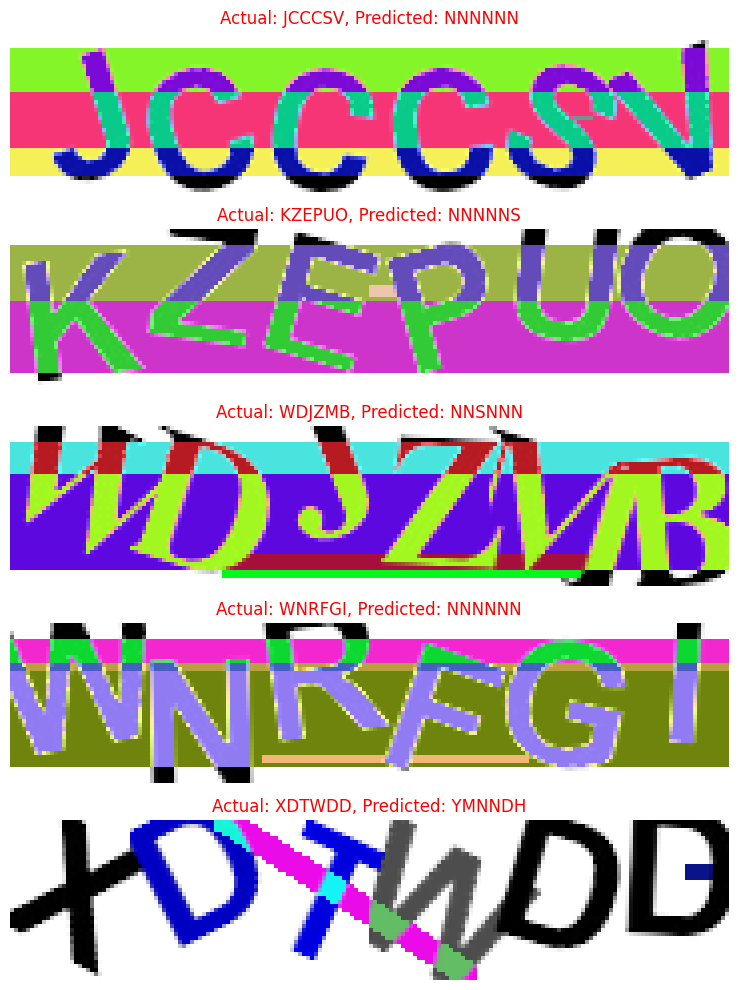

In [17]:
model = load_model('gray_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('gray_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = False

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(attn_output)

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x

flatten_layer_index = [index for index, layer in enumerate(model.layers) if isinstance(layer, Flatten)][0]
x = model.layers[flatten_layer_index + 2].output

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

# Add the output layer (same as before)
output = TimeDistributed(Dense(len(letters), activation='softmax'))(x)

# Create a new model
model = Model(inputs=model.input, outputs=output)

# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_2_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_2_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('gray_transformer_2_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_3_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_3_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('gray_transformer_3_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_4_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_4_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [ ]:
model = load_model('gray_transformer_4_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_5_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [15]:
model = load_model('gray_transformer_5_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

<Figure size 1000x1000 with 0 Axes>

In [ ]:
model = load_model('gray_transformer_5_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_6_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_6_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_7_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [14]:
model = load_model('gray_transformer_7_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

<Figure size 1000x1000 with 0 Axes>

In [ ]:
model = load_model('gray_transformer_7_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_8_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [12]:
model = load_model('gray_transformer_8_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

2024-02-17 05:11:37.934676: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: NameError: name 'draw_random_rectangle' is not defined
Traceback (most recent call last):

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_50096/387087317.py", line 13, in val_dataset
    yield create_image()
          ^^^^^^^^^^^^^^

  File "/tmp/ipykernel_50096/2331863168.py", line 8, in create_image
    draw_random_rectangle(img)
    ^

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NameError: name 'draw_random_rectangle' is not defined
Traceback (most recent call last):

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/mhs/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_50096/387087317.py", line 13, in val_dataset
    yield create_image()
          ^^^^^^^^^^^^^^

  File "/tmp/ipykernel_50096/2331863168.py", line 8, in create_image
    draw_random_rectangle(img)
    ^^^^^^^^^^^^^^^^^^^^^

NameError: name 'draw_random_rectangle' is not defined


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

<Figure size 1000x1000 with 0 Axes>

In [ ]:
model = load_model('gray_transformer_8_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('gray_transformer_9_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

In [ ]:
model = load_model('gray_transformer_9_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

In [13]:
model = load_model('gray_transformer_9_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 180, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 180, 1)           4         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 178, 32)          320       ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 38, 178, 32)          128       ['conv2d_1[0][0]']            
 Normalization)                                                                             

In [14]:
checkpoint = ModelCheckpoint('gray_transformer_10_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/200


2024-02-17 07:37:40.709713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-17 07:37:46.329377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 07:37:46.442787: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 07:37:46.797029: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 07:37:48.773205: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd4207ca500 initialized for platform CUDA (this does not guarantee th

     46/Unknown - 167s 3s/step - loss: 0.1692 - accuracy: 0.9518

2024-02-17 07:40:27.276065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-17 07:40:37.854739: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 5106463153454705271
2024-02-17 07:40:37.854791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1021934966568178689
2024-02-17 07:40:37.854803: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8805023037153341486
2024-02-17 07:40:37.854816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 

INFO:tensorflow:Assets written to: gray_transformer_10_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_10_model_checkpoint/assets


46/46 [==============================] - 179s 4s/step - loss: 0.1692 - accuracy: 0.9518 - val_loss: 0.1045 - val_accuracy: 0.9683 - lr: 0.0100
Epoch 2/200
 1/46 [..............................] - ETA: 4s - loss: 0.0682 - accuracy: 0.9727

2024-02-17 07:40:39.553807: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


46/46 [==============================] - 4s 98ms/step - loss: 0.0523 - accuracy: 0.9834 - val_loss: 0.1288 - val_accuracy: 0.9666 - lr: 0.0100
Epoch 3/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.1345 - val_accuracy: 0.9692 - lr: 0.0100
Epoch 4/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.1550 - val_accuracy: 0.9692 - lr: 0.0100
Epoch 5/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.2314 - val_accuracy: 0.9557 - lr: 0.0100
Epoch 6/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.1802 - val_accuracy: 0.9631 - lr: 0.0100
Epoch 7/200
46/46 [==============================] - 5s 101ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.1297 - val_accuracy: 0.9744 - lr: 1.0000e-03
Epoch 8/200
46/46 [==============================] - 5s 101ms/step - loss: 

1/1 [==============================] - 0s 13ms/step
Accuracy: 0.00%


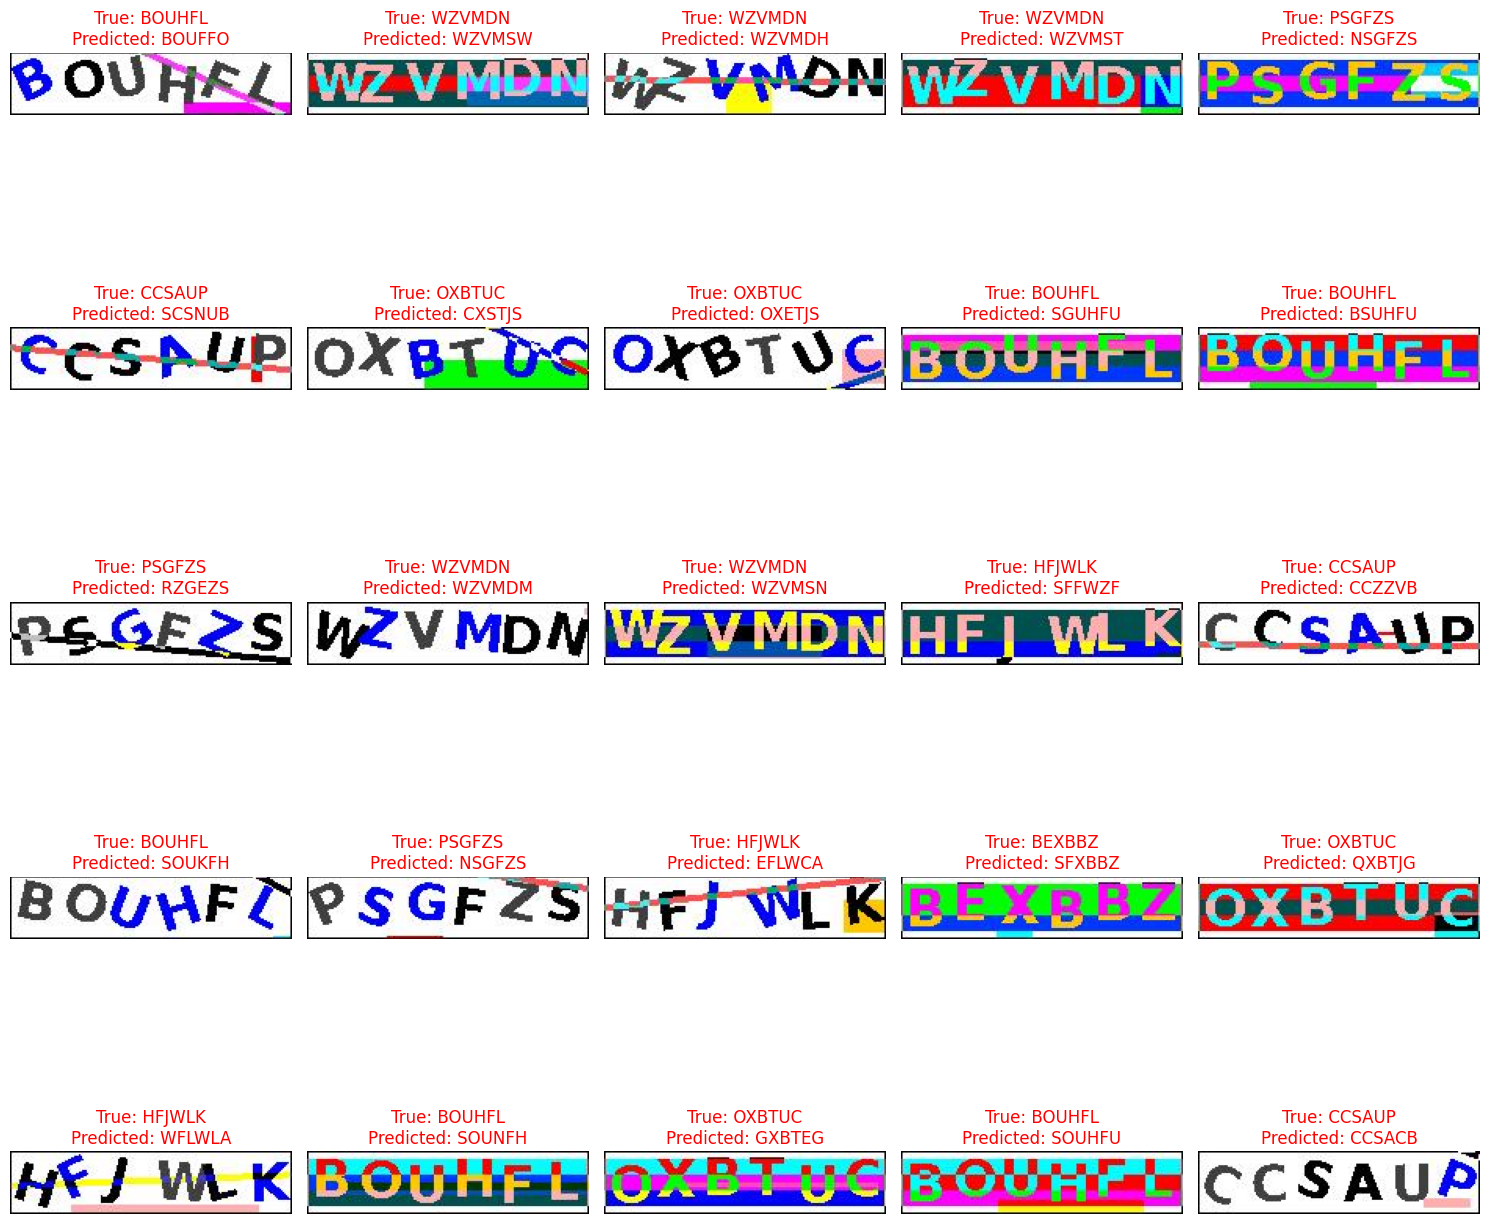

In [15]:
model = load_model('gray_transformer_10_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

In [13]:
model = load_model('gray_transformer_10_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 180, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 180, 1)           4         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 178, 32)          320       ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 38, 178, 32)          128       ['conv2d_1[0][0]']            
 Normalization)                                                                             

In [14]:
checkpoint = ModelCheckpoint('gray_transformer_11_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/200


2024-02-17 07:47:35.338565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-17 07:47:42.093016: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 07:47:42.148906: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 07:47:42.432889: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 07:47:44.473307: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fddcd334cc0 initialized for platform CUDA (this does not guarantee th

     46/Unknown - 173s 3s/step - loss: 0.1579 - accuracy: 0.9534

2024-02-17 07:50:28.296656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7869640900422269073
2024-02-17 07:50:28.296685: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2644192553631109809
2024-02-17 07:50:28.296693: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8892176791776607625
2024-02-17 07:50:28.296701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9557758589742872183
2024-02-17 07:50:28.296709: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4578784225444667135
2024-02-17 07:50:28.296729: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8473832511213926328
2024-02-17 07:50:28.340850: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator 

INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 186s 4s/step - loss: 0.1579 - accuracy: 0.9534 - val_loss: 0.2537 - val_accuracy: 0.9245 - lr: 0.0100
Epoch 2/200
 1/46 [..............................] - ETA: 4s - loss: 0.0540 - accuracy: 0.9831

2024-02-17 07:50:40.862620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


46/46 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9791INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 6s 131ms/step - loss: 0.0676 - accuracy: 0.9791 - val_loss: 0.2230 - val_accuracy: 0.9373 - lr: 0.0100
Epoch 3/200
46/46 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9866INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 7s 157ms/step - loss: 0.0423 - accuracy: 0.9866 - val_loss: 0.2077 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 4/200
46/46 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9870INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 7s 152ms/step - loss: 0.0405 - accuracy: 0.9870 - val_loss: 0.1842 - val_accuracy: 0.9581 - lr: 0.0100
Epoch 5/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 1.0414 - val_accuracy: 0.7806 - lr: 0.0100
Epoch 6/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0618 - accuracy: 0.9811 - val_loss: 0.2115 - val_accuracy: 0.9518 - lr: 0.0100
Epoch 7/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.2106 - val_accuracy: 0.9572 - lr: 0.0100
Epoch 8/200
46/46 [==============================] - 5s 101ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.1987 - val_accuracy: 0.9594 - lr: 0.0100
Epoch 9/200
46/46 [==============================] - 5s 101ms/step - loss: 0.0138 - accuracy: 0.9957 - val_loss: 0.1945 - val_accuracy: 0.9633 - lr: 0.0100
Epoch 10/200
46/46 [==============================] - ETA: 0s - loss: 0.0060 

INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 7s 147ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.1736 - val_accuracy: 0.9714 - lr: 1.0000e-03
Epoch 11/200
46/46 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9990INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 7s 143ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.1665 - val_accuracy: 0.9714 - lr: 1.0000e-03
Epoch 12/200
46/46 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9992INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 6s 139ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.1654 - val_accuracy: 0.9731 - lr: 1.0000e-03
Epoch 13/200
46/46 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_11_model_checkpoint/assets


46/46 [==============================] - 6s 141ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1631 - val_accuracy: 0.9733 - lr: 1.0000e-03
Epoch 14/200
46/46 [==============================] - 5s 102ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.1883 - val_accuracy: 0.9674 - lr: 1.0000e-03
Epoch 15/200
46/46 [==============================] - 5s 102ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.1784 - val_accuracy: 0.9701 - lr: 1.0000e-03
Epoch 16/200
46/46 [==============================] - 5s 102ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1754 - val_accuracy: 0.9709 - lr: 1.0000e-03
Epoch 17/200
46/46 [==============================] - 5s 103ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1770 - val_accuracy: 0.9705 - lr: 1.0000e-03
Epoch 18/200
46/46 [==============================] - 5s 103ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1752 - val_accuracy: 0.9718 - lr: 1.0000e-03
Epoch 19/200
46/46 [===========================

1/1 [==============================] - 0s 15ms/step
Accuracy: 12.00%


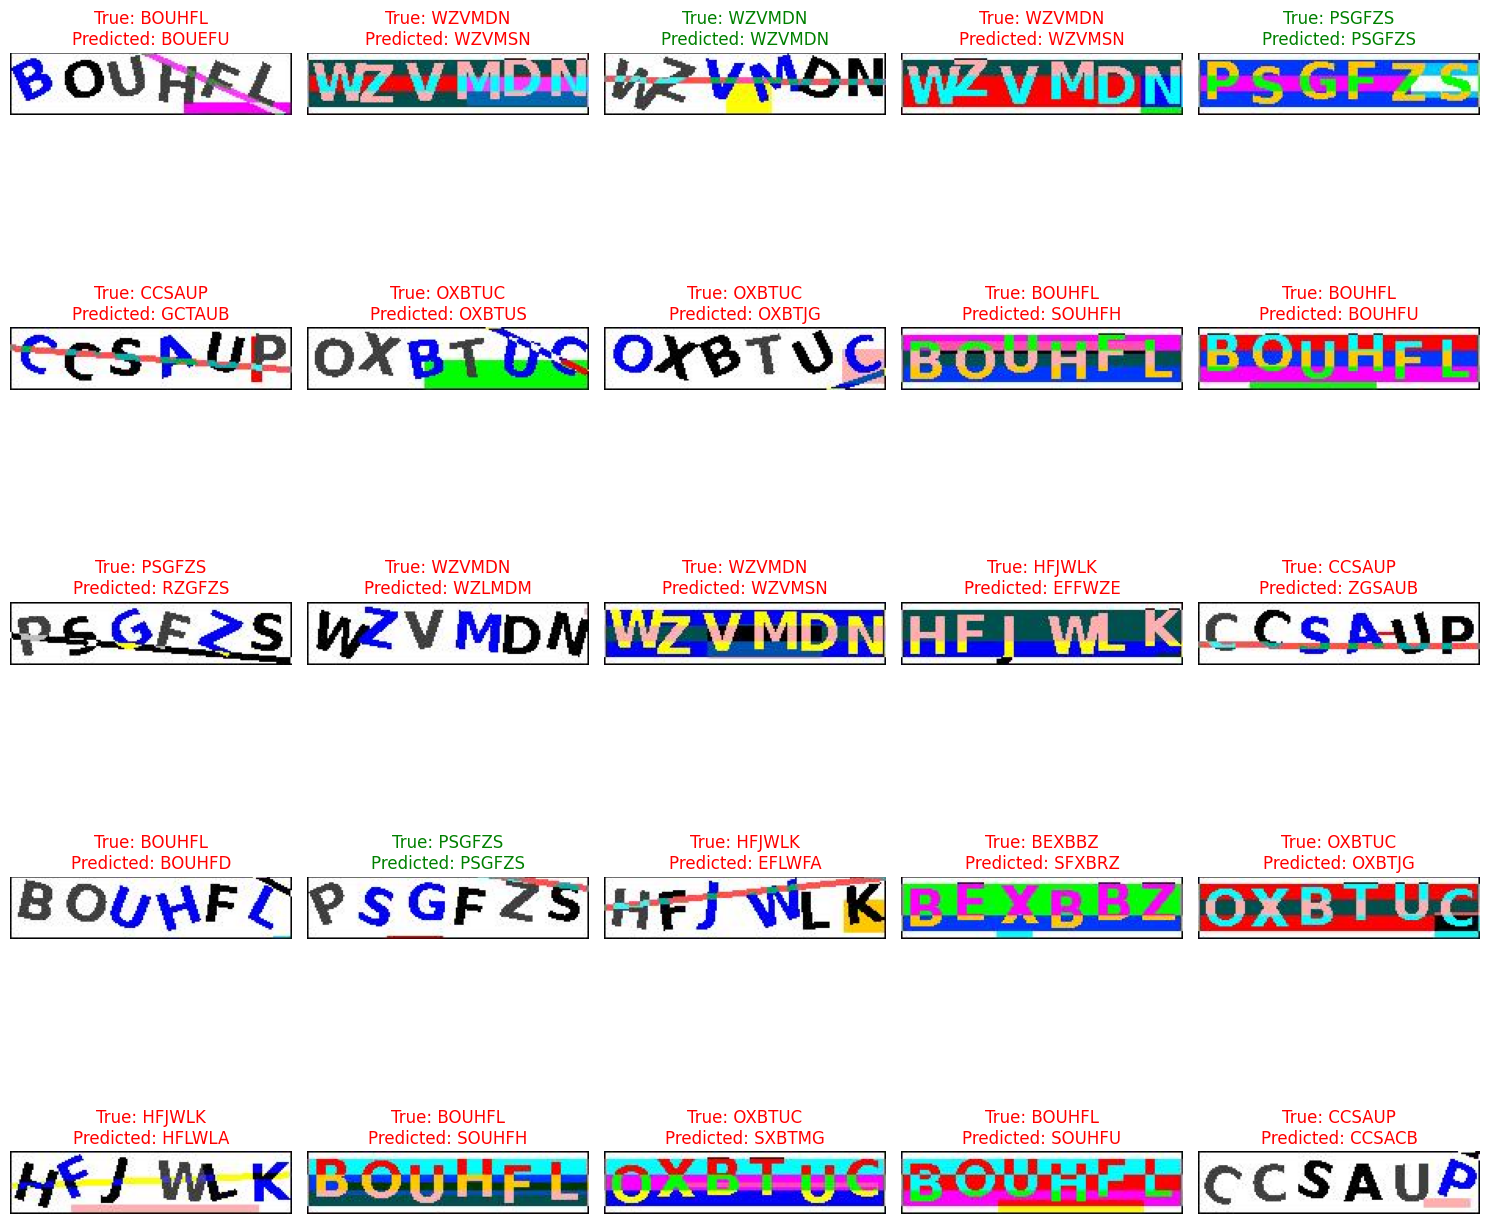

In [15]:
model = load_model('gray_transformer_11_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

In [13]:
model = load_model('gray_transformer_11_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 180, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 180, 1)           4         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 178, 32)          320       ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 38, 178, 32)          128       ['conv2d_1[0][0]']            
 Normalization)                                                                             

In [15]:
checkpoint = ModelCheckpoint('gray_transformer_12_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/200
     46/Unknown - 4s 94ms/step - loss: 0.0037 - accuracy: 0.9992

2024-02-17 08:00:06.189941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2731264116969413973
2024-02-17 08:00:06.189968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13691362214017349531
2024-02-17 08:00:06.189976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13605244510845368480
2024-02-17 08:00:06.189994: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14036740904981419604
2024-02-17 08:00:06.305807: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7451891572160869023
2024-02-17 08:00:06.305863: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7638826939398601283
2024-02-17 08:00:06.305872: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send 

INFO:tensorflow:Assets written to: gray_transformer_12_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_12_model_checkpoint/assets


46/46 [==============================] - 7s 144ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.1648 - val_accuracy: 0.9705 - lr: 1.0000e-04
Epoch 2/200
46/46 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993INFO:tensorflow:Assets written to: gray_transformer_12_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_12_model_checkpoint/assets


46/46 [==============================] - 7s 148ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1648 - val_accuracy: 0.9705 - lr: 1.0000e-04
Epoch 3/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.1651 - val_accuracy: 0.9701 - lr: 1.0000e-04
Epoch 4/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1658 - val_accuracy: 0.9701 - lr: 1.0000e-04
Epoch 5/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.1662 - val_accuracy: 0.9703 - lr: 1.0000e-04
Epoch 6/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1665 - val_accuracy: 0.9703 - lr: 1.0000e-04
Epoch 7/200
46/46 [==============================] - 5s 101ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1665 - val_accuracy: 0.9705 - lr: 1.0000e-05
Epoch 8/200
46/46 [==============================] - 5

1/1 [==============================] - 0s 15ms/step
Accuracy: 8.00%


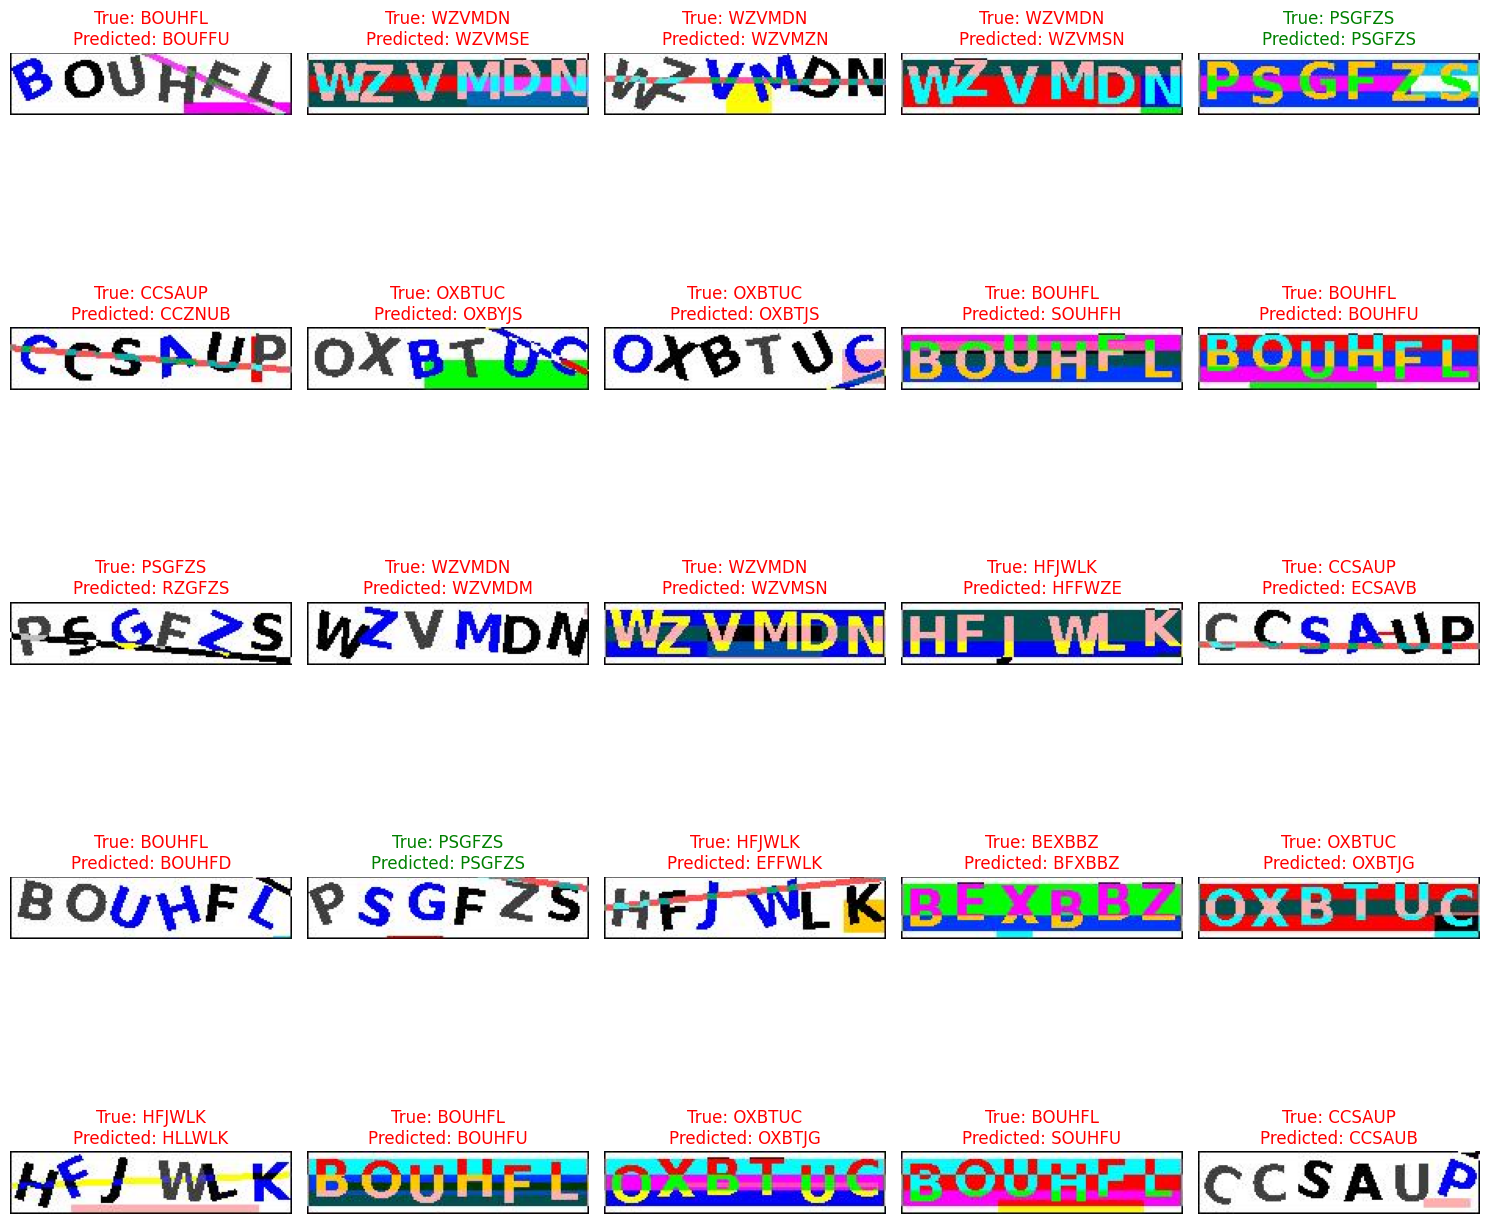

In [16]:
model = load_model('gray_transformer_12_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

In [13]:
model = load_model('gray_transformer_12_model_checkpoint')

# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = True
    
# Recompile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 180, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 180, 1)           4         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 178, 32)          320       ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 38, 178, 32)          128       ['conv2d_1[0][0]']            
 Normalization)                                                                             

In [14]:
checkpoint = ModelCheckpoint('gray_transformer_13_model_checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min')

history = model.fit(training_dataset, epochs=200, batch_size=batch_size, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/200


2024-02-17 08:04:46.410187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-17 08:04:52.392286: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 08:04:52.444539: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 08:04:52.726991: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-17 08:04:54.722674: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff1e47c1c90 initialized for platform CUDA (this does not guarantee th

     46/Unknown - 175s 4s/step - loss: 0.1905 - accuracy: 0.9468

2024-02-17 08:07:41.756216: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8814452056440876521
2024-02-17 08:07:41.756237: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10502666137979148518
2024-02-17 08:07:41.756241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10960040565789437158
2024-02-17 08:07:41.756251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14374023346651993130
2024-02-17 08:07:41.804437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cach

INFO:tensorflow:Assets written to: gray_transformer_13_model_checkpoint/assets


INFO:tensorflow:Assets written to: gray_transformer_13_model_checkpoint/assets


46/46 [==============================] - 188s 4s/step - loss: 0.1905 - accuracy: 0.9468 - val_loss: 0.1925 - val_accuracy: 0.9416 - lr: 0.0100
Epoch 2/200
 1/46 [..............................] - ETA: 4s - loss: 0.0828 - accuracy: 0.9785

2024-02-17 08:07:54.096675: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


46/46 [==============================] - 4s 97ms/step - loss: 0.0760 - accuracy: 0.9771 - val_loss: 0.2357 - val_accuracy: 0.9358 - lr: 0.0100
Epoch 3/200
46/46 [==============================] - 4s 98ms/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 0.2540 - val_accuracy: 0.9464 - lr: 0.0100
Epoch 4/200
46/46 [==============================] - 5s 98ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.3083 - val_accuracy: 0.9382 - lr: 0.0100
Epoch 5/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0389 - accuracy: 0.9877 - val_loss: 0.4113 - val_accuracy: 0.9312 - lr: 0.0100
Epoch 6/200
46/46 [==============================] - 5s 99ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.4239 - val_accuracy: 0.9069 - lr: 0.0100
Epoch 7/200
46/46 [==============================] - 5s 100ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.2040 - val_accuracy: 0.9618 - lr: 1.0000e-03
Epoch 8/200
46/46 [==============================] - 5s 100ms/step - loss: 0.

1/1 [==============================] - 0s 14ms/step
Accuracy: 8.00%


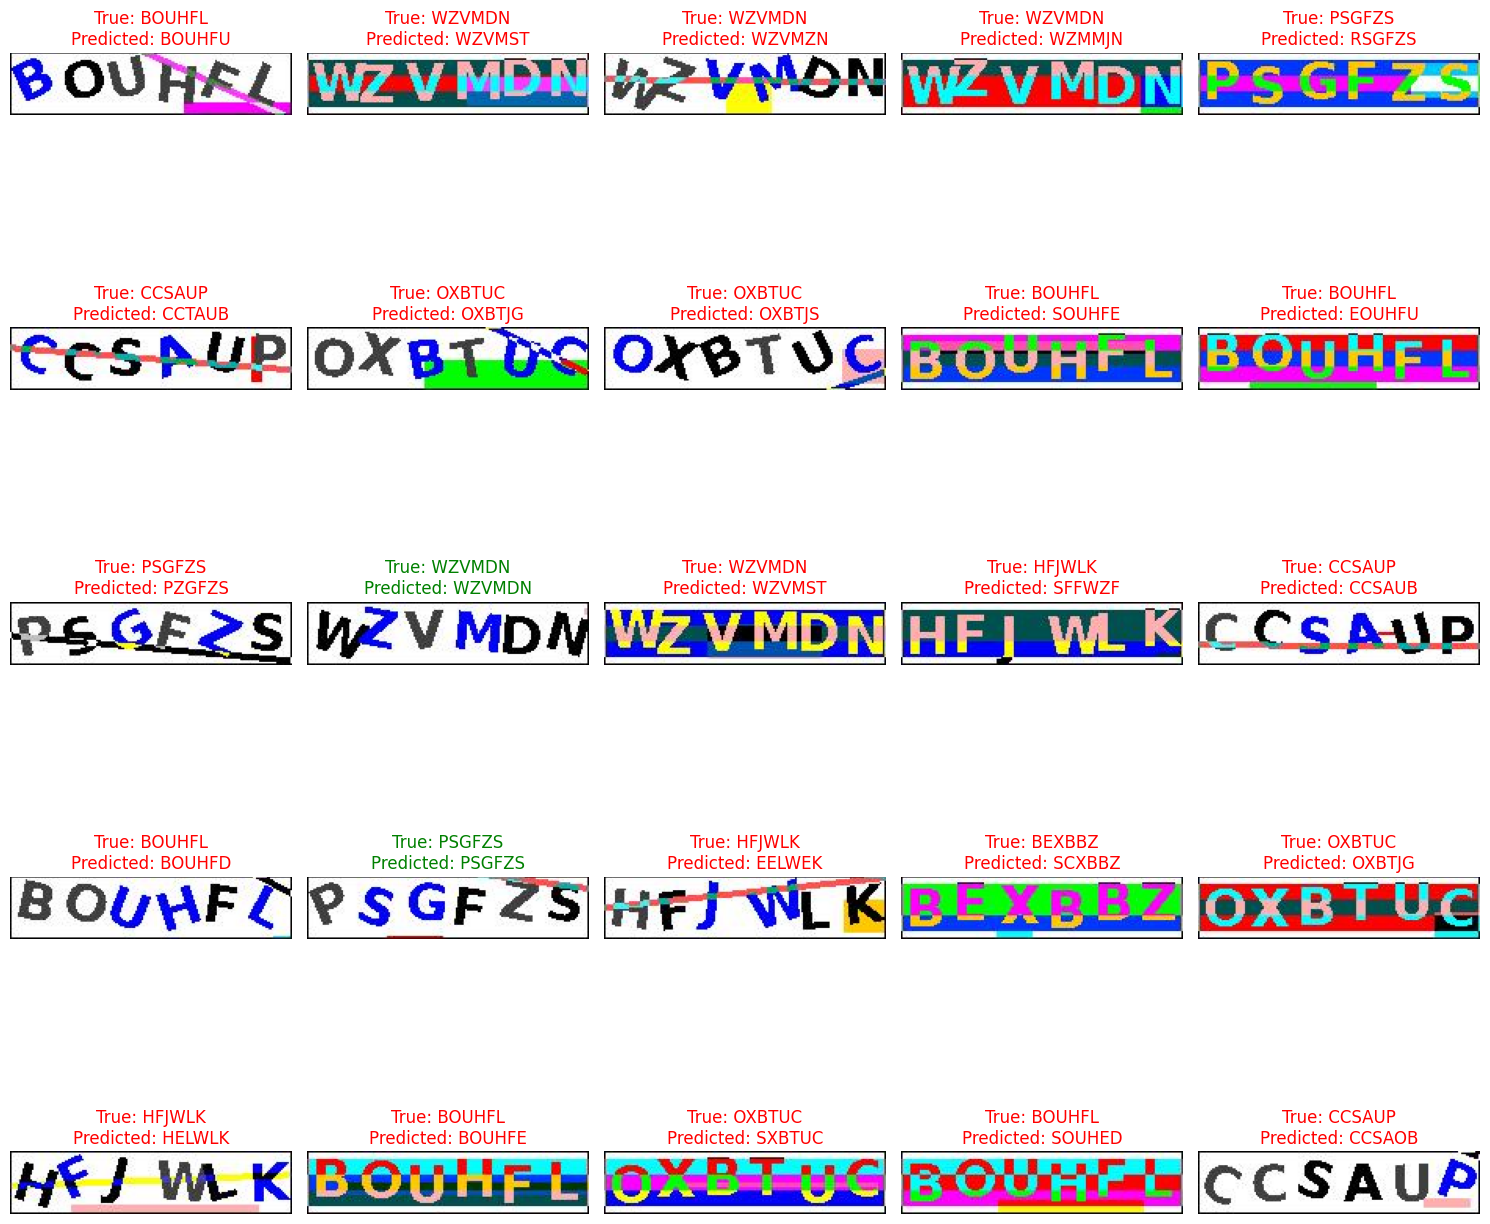

In [17]:
model = load_model('gray_transformer_13_model_checkpoint')
def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

# Define the directory where your dataset is stored
dataset_dir = 'data'

# Initialize variables to keep track of correct predictions
total_images = 0
correct_predictions = 0

# Calculate the number of rows and columns for subplots
num_images = min(len(os.listdir(dataset_dir)), 25)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Set up matplotlib figure
plt.figure(figsize=(15, 3 * num_rows))

# Iterate through each image in the dataset directory
for i, filename in enumerate(os.listdir(dataset_dir)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # assuming images are jpg or png format
        if i >= 25:  # Limit to 25 images
            break

        # Load the image and preprocess it
        img_path = os.path.join(dataset_dir, filename)
        img = image.load_img(img_path, target_size=(40, 180))  # Specify your image dimensions
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the label for the image
        predictions = model.predict(img_array)
        predicted_label = one_hot_to_text(predictions[0])  # Convert one-hot encoded predictions to text label

        # Extract the true label from the filename (first 6 letters)
        true_label = filename[:6]

        # Compare the predicted label with the true label
        if predicted_label == true_label:
            correct_predictions += 1
            color = 'green'
        else:
            color = 'red'

        # Display the image along with true and predicted labels
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')

        total_images += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print("Accuracy: {:.2f}%".format(accuracy))

plt.tight_layout()
plt.show()

2024-02-18 00:55:00.942075: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-18 00:55:01.106749: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 12ms/step


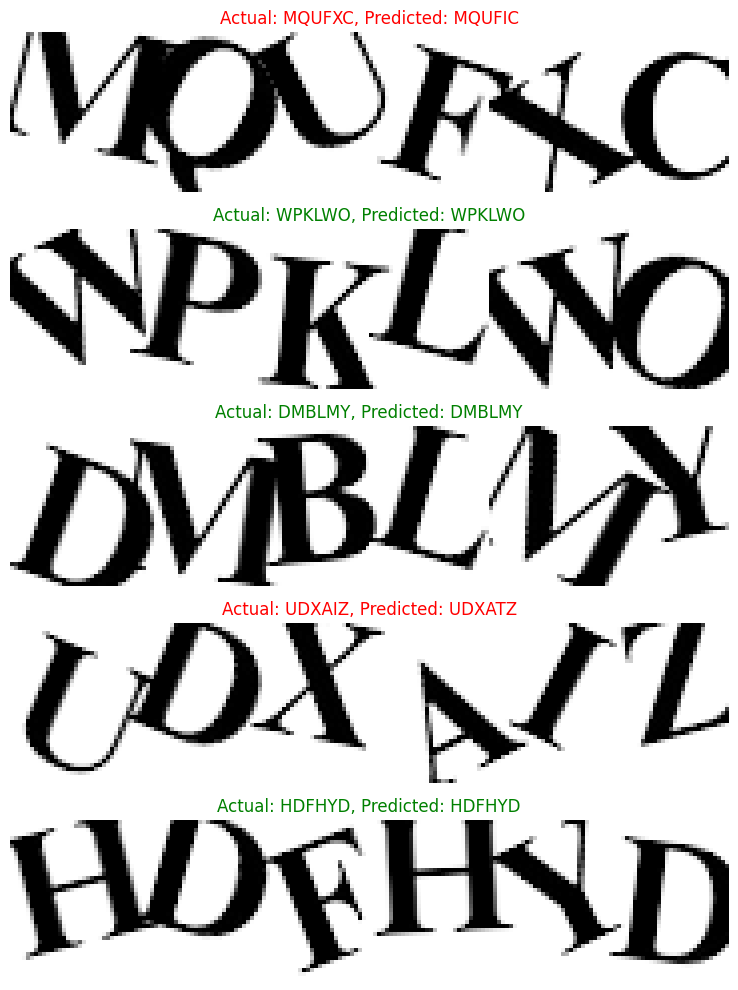

In [34]:
model = load_model('gray_transformer_13_model_checkpoint')

def one_hot_to_text(one_hot_encoded):
    return ''.join([letters[np.argmax(vec)] for vec in one_hot_encoded])

def plot_predictions(model, dataset, num_examples=5):
    plt.figure(figsize=(10, 2 * num_examples))
    
    for i, (images, true_labels) in enumerate(dataset.unbatch().take(num_examples)):
        preds = model.predict(tf.expand_dims(images, 0))
        pred_text = one_hot_to_text(preds[0])
        true_text = one_hot_to_text(true_labels)
        
        # Plotting
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images)
        if true_text == pred_text:
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="green")
        else: 
            plt.title(f'Actual: {true_text}, Predicted: {pred_text}', color="red")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, validation_dataset)

In [39]:
num_classes = len(letters)  # Replace 'len(letters)' with the actual number of classes

input_layer = Input(shape=(40, 180, 3))

# Conv2D layer to transform 3 channels to 1 channel using a (3, 1) kernel
x = Conv2D(1, (3, 1), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)

# First Convolutional Block with Residual Connection
shortcut = x  # Save shortcut for skip connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block with Residual Connection
shortcut = x  # Save shortcut for skip connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([shortcut, x])  # Add skip connection
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and reshape for attention
x = Flatten()(x)
x = Dense(510, activation='relu')(x)
x = Reshape((6, -1))(x)

# LSTM Layer
x = LSTM(128, return_sequences=True)(x)

# Output Layer
output = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 40, 180, 3)]         0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 40, 180, 1)           10        ['input_19[0][0]']            
                                                                                                  
 batch_normalization_50 (Ba  (None, 40, 180, 1)           4         ['conv2d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_51 (Conv2D)          (None, 40, 180, 32)          320       ['batch_normalization_50